In [1]:
import pandas as pd

# Load the original dataset with correct date parsing (mm/dd/yy format)
data = pd.read_csv("Data_with_Bubbles.csv", parse_dates=["Date"], date_format="%m/%d/%y")

# Rename variables (remove "_YoY" from names)
rename_map = {
    "TR_CAPE_YoY": "TR_CAPE",
    "M2_YoY": "M2",
    "Gold_YoY": "Gold",
    "BankCredit_YoY": "BankCredit"
}
data = data.rename(columns=rename_map)

# Save cleaned version again
data.to_csv("Data_with_Bubbles_Renamed.csv", index=False)
print("File saved as 'Data_with_Bubbles_Renamed.csv' and ready for lag selection analysis")


File saved as 'Data_with_Bubbles_Renamed.csv' and ready for lag selection analysis


In [26]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Load dataset
data = pd.read_csv("Data_with_Bubbles_Renamed.csv", parse_dates=["Date"])
data = data.set_index("Date")

variables = [
    "Real_Rate", "TR_CAPE", "M2", "Gold",
    "Baa_Spread", "VIX", "BankCredit",
    "Michigan_Sentiment", "Policy_Deviations"
]

# Tables to store values
aic_table = pd.DataFrame(index=variables, columns=[f"Lag {i}" for i in range(1, 7)])
bic_table = pd.DataFrame(index=variables, columns=[f"Lag {i}" for i in range(1, 7)])
chosen_lags = {}

for var in variables:
    results = []

    for lag in range(1, 7):
        df = data[[var, "Bubble"]].copy()
        for l in range(1, lag+1):
            df[f"{var}_lag{l}"] = df[var].shift(l)
        df = df.dropna()

        y = df["Bubble"]
        X = sm.add_constant(df[[f"{var}_lag{l}" for l in range(1, lag+1)]])

        try:
            model = sm.Probit(y, X).fit(disp=0)
            aic, bic = model.aic, model.bic
        except:
            aic, bic = np.nan, np.nan

        aic_table.loc[var, f"Lag {lag}"] = round(aic, 2) if pd.notnull(aic) else np.nan
        bic_table.loc[var, f"Lag {lag}"] = round(bic, 2) if pd.notnull(bic) else np.nan
        results.append((lag, aic, bic))

    # Find optimal by "max of minima" rule
    min_aic_lag = min(results, key=lambda x: x[1] if not np.isnan(x[1]) else np.inf)[0]
    min_bic_lag = min(results, key=lambda x: x[2] if not np.isnan(x[2]) else np.inf)[0]
    chosen_lag = max(min_aic_lag, min_bic_lag)

    chosen_lags[var] = chosen_lag

# Save results
aic_table.to_csv("Lag_Selection_AIC_MaxRule.csv")
bic_table.to_csv("Lag_Selection_BIC_MaxRule.csv")

# Save chosen lags as summary CSV
lag_summary = pd.DataFrame(list(chosen_lags.items()), columns=["Variable", "Chosen_Lag"])
lag_summary.to_csv("Lag_Selection_Summary.csv", index=False)

print("Saved:")
print("- Lag_Selection_AIC_MaxRule.csv")
print("- Lag_Selection_BIC_MaxRule.csv")
print("- Lag_Selection_Summary.csv (final chosen lags)")



Saved:
- Lag_Selection_AIC_MaxRule.csv
- Lag_Selection_BIC_MaxRule.csv
- Lag_Selection_Summary.csv (final chosen lags)


In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import norm

# -------------------------
# 1. Load data
# -------------------------
data = pd.read_csv("Data_with_Bubbles_Renamed.csv", parse_dates=["Date"])
data = data.set_index("Date")

# -------------------------
# 2. Create lagged variables (as per paper Table 1)
# -------------------------
lags = {
    "Real_Rate": 6,
    "TR_CAPE": 6,
    "M2": 3,
    "Gold": 1,
    "Baa_Spread": 6,
    "VIX": 1,
    "BankCredit": 6,
    "Michigan_Sentiment": 6,
    "Policy_Deviations": 6,
}

for var, lag in lags.items():
    data[f"{var}_lag{lag}"] = data[var].shift(lag)

# Lagged dependent variable and predicted probability placeholders
data["Bubble_lag1"] = data["Bubble"].shift(1)

# Drop missing values from lagging
data = data.dropna()

# -------------------------
# 3. Helper functions
# -------------------------
def add_significance(pval):
    if pval < 0.01:
        return "***"
    elif pval < 0.05:
        return "**"
    elif pval < 0.1:
        return "*"
    return ""

def estrella_r2(llf, llnull, n):
    # Estrella (1998) R² measure
    return 1 - np.exp((2 / n) * (llnull - llf))

def classification_metrics(model, X, y, thresholds=[0.25, 0.5]):
    y_pred = model.predict(X)
    metrics = {}
    for thr in thresholds:
        y_class = (y_pred >= thr).astype(int)
        acc = (y_class == y).mean()
        metrics[thr] = acc
    return metrics

def format_results_table(results, model_name):
    table = []
    for coef, se, pval, name in zip(results.params, results.bse, results.pvalues, results.params.index):
        stars = add_significance(pval)
        table.append([name, f"{coef:.3f}{stars}", f"({se:.3f})"])
    df = pd.DataFrame(table, columns=["Variable", model_name, "Std. Err."])
    return df

# -------------------------
# 4. Model Estimation
# -------------------------
# Independent variables (at chosen lags)
X_static = data[[f"{var}_lag{lag}" for var, lag in lags.items()]]
y = data["Bubble"]

# Static probit
X_static = sm.add_constant(X_static)
model_static = sm.Probit(y, X_static).fit(disp=0)

# Dynamic probit
X_dynamic = data[[f"{var}_lag{lag}" for var, lag in lags.items()] + ["Bubble_lag1"]]
X_dynamic = sm.add_constant(X_dynamic)
model_dynamic = sm.Probit(y, X_dynamic).fit(disp=0)

# Dynamic Autoregressive probit
# Add lagged predicted probability from dynamic model
data["Prob_lag1"] = model_dynamic.predict(X_dynamic).shift(1)
X_dynar = data[[f"{var}_lag{lag}" for var, lag in lags.items()] + ["Bubble_lag1", "Prob_lag1"]].dropna()
y_dynar = data.loc[X_dynar.index, "Bubble"]
X_dynar = sm.add_constant(X_dynar)
model_dynar = sm.Probit(y_dynar, X_dynar).fit(disp=0)

# -------------------------
# 5. Build Table 3
# -------------------------
table3_static = format_results_table(model_static, "Static Model")
table3_dynamic = format_results_table(model_dynamic, "Dynamic Model")
table3_dynar = format_results_table(model_dynar, "Dynamic AR Model")

# Merge tables side by side (like dissertation)
table3 = table3_static.merge(table3_dynamic, on="Variable", how="outer", suffixes=("", "_dyn"))
table3 = table3.merge(table3_dynar, on="Variable", how="outer", suffixes=("", "_dynar"))

print("\n=== Table 3: Probit Coefficient Results for Multivariate Forecasting Models ===")
print(table3.to_string(index=False))
print("\nSignificance levels: * p < 0.1, ** p < 0.05, *** p < 0.01")
print("Note: The reported coefficients represent changes in the latent index, not the probability of a bubble.")

# -------------------------
# 6. Build Table 4
# -------------------------
metrics_static = classification_metrics(model_static, X_static, y)
metrics_dynamic = classification_metrics(model_dynamic, X_dynamic, y)
metrics_dynar = classification_metrics(model_dynar, X_dynar, y_dynar)

llnull = sm.Probit(y, np.ones(len(y))).fit(disp=0).llf

table4 = pd.DataFrame({
    "Metric": ["Log-Likelihood", "AIC", "BIC", "Accuracy (50% Threshold)", "Accuracy (25% Threshold)", "Estrella R²"],
    "Static": [
        model_static.llf,
        model_static.aic,
        model_static.bic,
        metrics_static[0.5],
        metrics_static[0.25],
        estrella_r2(model_static.llf, llnull, len(y))
    ],
    "Dynamic": [
        model_dynamic.llf,
        model_dynamic.aic,
        model_dynamic.bic,
        metrics_dynamic[0.5],
        metrics_dynamic[0.25],
        estrella_r2(model_dynamic.llf, llnull, len(y))
    ],
    "Dynamic AR": [
        model_dynar.llf,
        model_dynar.aic,
        model_dynar.bic,
        metrics_dynar[0.5],
        metrics_dynar[0.25],
        estrella_r2(model_dynar.llf, llnull, len(y_dynar))
    ]
})

print("\n=== Table 4: Model Fit and Predictive Accuracy ===")
print(table4.to_string(index=False))



=== Table 3: Probit Coefficient Results for Multivariate Forecasting Models ===
               Variable Static Model Std. Err. Dynamic Model Std. Err._dyn Dynamic AR Model Std. Err._dynar
        Baa_Spread_lag6    -1.867***   (0.307)     -1.283***       (0.379)        -1.080***         (0.397)
        BankCredit_lag6    -0.174***   (0.054)      -0.133**       (0.068)          -0.133*         (0.071)
            Bubble_lag1          NaN       NaN      2.372***       (0.274)         1.907***         (0.330)
              Gold_lag1       -0.013   (0.008)        -0.006       (0.011)           -0.001         (0.011)
                M2_lag3     0.277***   (0.041)      0.160***       (0.049)          0.128**         (0.052)
Michigan_Sentiment_lag6      0.023**   (0.011)         0.017       (0.013)            0.016         (0.014)
 Policy_Deviations_lag6    -0.599***   (0.208)        -0.142       (0.265)           -0.050         (0.278)
              Prob_lag1          NaN       NaN         

In [4]:
import matplotlib.pyplot as plt

def save_table_as_png(df, title, filename):
    fig, ax = plt.subplots(figsize=(12, len(df) * 0.6 + 1))
    ax.axis('off')
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.title(title, fontsize=14, pad=20)
    plt.savefig(filename, bbox_inches="tight", dpi=300)
    plt.close()

# Save Table 3
save_table_as_png(table3, "Table 3: Probit Coefficient Results for Multivariate Forecasting Models", "Table3.png")

# Save Table 4
save_table_as_png(table4, "Table 4: Model Fit and Predictive Accuracy", "Table4.png")

print("Tables saved as Table3.png and Table4.png")


Tables saved as Table3.png and Table4.png


In [5]:
from sklearn.metrics import confusion_matrix
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import binomtest
import matplotlib.pyplot as plt

# -------------------------------
# Classification metrics function
# -------------------------------
def classification_metrics_summary(model, X, y, model_name, threshold=0.5):
    """
    Compute classification metrics for Appendix A.5 (summary stats).
    """
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob >= threshold).astype(int)

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    # Metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tn / (tn + fp) if (tn + fp) > 0 else np.nan   # No-Bubble correctly identified
    specificity = tp / (tp + fn) if (tp + fn) > 0 else np.nan   # Bubble correctly identified
    balanced_acc = (sensitivity + specificity) / 2

    # 95% CI for accuracy
    ci_low, ci_high = proportion_confint(int((y_pred == y).sum()), len(y), alpha=0.05, method='wilson')

    # No Information Rate (majority class proportion)
    nir = max(y.value_counts()) / len(y)

    # P-value (binomial test of accuracy > NIR)
    p_val = binomtest(int((y_pred == y).sum()), len(y), nir, alternative="greater").pvalue

    return {
        "Metric": [
            "Accuracy",
            "95% CI for Accuracy",
            "Sensitivity (No-Bubble)",
            "Specificity (Bubble)",
            "Balanced Accuracy",
            "No Information Rate (NIR)",
            "P-Value [Acc > NIR]",
        ],
        model_name: [
            f"{accuracy*100:.1f}%",
            f"({ci_low*100:.1f}%, {ci_high*100:.1f}%)",
            f"{sensitivity*100:.1f}%",
            f"{specificity*100:.1f}%",
            f"{balanced_acc*100:.2f}%",
            f"{nir*100:.1f}%",
            f"{p_val:.3f}",
        ],
    }

# -------------------------------
# Build Appendix A.5 table
# -------------------------------
table_A5 = pd.DataFrame({"Metric": [
    "Accuracy",
    "95% CI for Accuracy",
    "Sensitivity (No-Bubble)",
    "Specificity (Bubble)",
    "Balanced Accuracy",
    "No Information Rate (NIR)",
    "P-Value [Acc > NIR]"
]})

for model_name, (model, X, yvals) in {
    "Static Model": (model_static, X_static, y),
    "Dynamic Model": (model_dynamic, X_dynamic, y),
    "Dynamic AR Model": (model_dynar, X_dynar, y_dynar),
}.items():
    res = classification_metrics_summary(model, X, yvals, model_name)
    df_res = pd.DataFrame(res)
    table_A5 = table_A5.merge(df_res, on="Metric")

print("\n=== Appendix A.5: Model Classification Results ===")
print(table_A5.to_string(index=False))

# -------------------------------
# Save table as PNG (no footnote)
# -------------------------------
def save_table_as_png(df, title, filename):
    fig, ax = plt.subplots(figsize=(12, len(df) * 0.6 + 1))
    ax.axis('off')
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.title(title, fontsize=14, pad=20)
    plt.savefig(filename, bbox_inches="tight", dpi=300)
    plt.close()

save_table_as_png(table_A5, "Appendix A.5: Model Classification Results", "Appendix_A5.png")

print("✅ Appendix A.5 saved as Appendix_A5.png")


=== Appendix A.5: Model Classification Results ===
                   Metric   Static Model  Dynamic Model Dynamic AR Model
                 Accuracy          90.9%          94.7%            94.7%
      95% CI for Accuracy (87.7%, 93.4%) (92.0%, 96.5%)   (92.0%, 96.5%)
  Sensitivity (No-Bubble)          97.0%          96.4%            96.7%
     Specificity (Bubble)          70.3%          89.0%            87.9%
        Balanced Accuracy         83.69%         92.70%           92.31%
No Information Rate (NIR)          77.0%          77.0%            77.0%
      P-Value [Acc > NIR]          0.000          0.000            0.000
✅ Appendix A.5 saved as Appendix_A5.png


In [7]:
# Ensure probabilities are stored
# -------------------------------
data["Static_Prob"] = model_static.predict(X_static)
data["Dynamic_Prob"] = model_dynamic.predict(X_dynamic)
data.loc[X_dynar.index, "DynamicAR_Prob"] = model_dynar.predict(X_dynar)

# -------------------------------
# Plot setup
# -------------------------------
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

models = [
    ("Static Model", "Static_Prob", "blue"),
    ("Dynamic Model", "Dynamic_Prob", "red"),
    ("Dynamic AR Model", "DynamicAR_Prob", "green")
]

for ax, (title, col, color) in zip(axes, models):
    ax.plot(data.index, data[col], label=f"{title}", color=color, linewidth=1.2)
    ax.fill_between(data.index, 0, data["Bubble"], color="gray", alpha=0.3, step="pre", label="Bubble Periods")
    ax.set_title(title, fontsize=12)
    ax.set_ylabel("Probability")
    ax.set_ylim(0, 1.05)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(loc="upper left", fontsize=9)

axes[-1].set_xlabel("Date")

fig.suptitle("Figure 5: In-Sample Predicted Bubble Probabilities", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])

# Save figure
plt.savefig("Figure5.png", dpi=300, bbox_inches="tight")
plt.close()

print("Figure 5 saved as Figure5.png (3 panels)")


Figure 5 saved as Figure5.png (3 panels)


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------
# 1. Build lagged explanatory dataset
# -------------------------------
lags = {
    "Real_Rate": 6,
    "TR_CAPE": 6,
    "M2": 3,
    "Gold": 1,
    "Baa_Spread": 6,
    "VIX": 1,
    "BankCredit": 6,
    "Michigan_Sentiment": 6,
    "Policy_Deviations": 6,
}

lagged_data = pd.DataFrame(index=data.index)

for var, lag in lags.items():
    lagged_data[var] = data[var].shift(lag)

lagged_data = lagged_data.dropna()

# -------------------------------
# 2. Compute correlation matrix
# -------------------------------
corr_matrix = lagged_data.corr()

print("\n=== Appendix A.4: Correlation Matrix ===")
print(corr_matrix.round(2))

# -------------------------------
# 3. Save as PNG (heatmap)
# -------------------------------
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Appendix A.4: Correlation Matrix of Explanatory Variables", fontsize=14, pad=20)
plt.tight_layout()
plt.savefig("Appendix_A4.png", dpi=300, bbox_inches="tight")
plt.close()

print("Appendix A.4 correlation matrix saved as Appendix_A4.png")



=== Appendix A.4: Correlation Matrix ===
                    Real_Rate  TR_CAPE    M2  Gold  Baa_Spread   VIX  \
Real_Rate                1.00     0.17 -0.26 -0.04       -0.26 -0.03   
TR_CAPE                  0.17     1.00 -0.04 -0.16       -0.53 -0.22   
M2                      -0.26    -0.04  1.00  0.11        0.34  0.35   
Gold                    -0.04    -0.16  0.11  1.00        0.16  0.09   
Baa_Spread              -0.26    -0.53  0.34  0.16        1.00  0.36   
VIX                     -0.03    -0.22  0.35  0.09        0.36  1.00   
BankCredit              -0.00    -0.21  0.27 -0.02       -0.16  0.01   
Michigan_Sentiment       0.49     0.30  0.04 -0.26       -0.42 -0.13   
Policy_Deviations        0.86     0.24 -0.29 -0.00       -0.11 -0.13   

                    BankCredit  Michigan_Sentiment  Policy_Deviations  
Real_Rate                -0.00                0.49               0.86  
TR_CAPE                  -0.21                0.30               0.24  
M2                   

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# -------------------------------
# Helper: Classification metrics
# -------------------------------
def classification_metrics_extended(model, X, y, threshold):
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tn / (tn + fp) if (tn + fp) > 0 else np.nan   # No-Bubble correctly identified
    specificity = tp / (tp + fn) if (tp + fn) > 0 else np.nan   # Bubble correctly identified
    return acc, sensitivity, specificity

# -------------------------------
# Step 6: Univariate Probits at Lag 1
# -------------------------------
def univariate_probit_lag1(var):
    """
    Fit univariate probit with lag 1 for a given variable.
    """
    X = data[[f"{var}_lag1"]].dropna()
    y = data.loc[X.index, "Bubble"]
    X = sm.add_constant(X)
    model = sm.Probit(y, X).fit(disp=0)
    return model, X, y

# Create lag1 versions of all explanatory variables
for var in lags.keys():
    data[f"{var}_lag1"] = data[var].shift(1)

# Fit univariate models (lag 1)
univariate_models_lag1 = {}
for var in lags.keys():
    model, X, yvals = univariate_probit_lag1(var)
    univariate_models_lag1[var] = (model, X, yvals)

# -------------------------------
# Table 5 (Lag 1 with threshold filtering)
# -------------------------------
rows = []
for var, (model, X, yvals) in univariate_models_lag1.items():
    y_pred_prob = model.predict(X)
    max_prob = y_pred_prob.max()

    for thr in [0.25, 0.5]:
        if max_prob >= thr:   # Only include if threshold is reached
            acc, sens, spec = classification_metrics_extended(model, X, yvals, thr)
            rows.append([
                var,
                thr,
                f"{acc*100:.2f}%",
                f"{sens*100:.2f}%",
                f"{spec*100:.2f}%"
            ])

table5_lag1 = pd.DataFrame(rows, columns=["Variable", "Threshold", "Accuracy", "Sensitivity", "Specificity"])

print("\n=== Table 5 (Lag 1): Univariate Probit Model Classification Results ===")
print(table5_lag1.to_string(index=False))

# Save as PNG
def save_table_as_png(df, title, filename):
    fig, ax = plt.subplots(figsize=(12, len(df) * 0.6 + 1))
    ax.axis('off')
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.title(title, fontsize=14, pad=20)
    plt.savefig(filename, bbox_inches="tight", dpi=300)
    plt.close()

save_table_as_png(table5_lag1, "Table 5 (Lag 1): Univariate Probit Classification Results", "Table5_Lag1.png")
print("Table 5 (Lag 1) saved as Table5_Lag1.png")

# -------------------------------
# Figure 6 (Lag 1 predicted probabilities)
# -------------------------------
fig, axes = plt.subplots(3, 3, figsize=(16, 10), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (var, (model, X, yvals)) in zip(axes, univariate_models_lag1.items()):
    probs = model.predict(X)
    ax.plot(X.index, probs, label=f"{var} (lag 1)", color="blue", linewidth=1.2)
    ax.fill_between(X.index, 0, yvals, color="gray", alpha=0.3, step="pre")
    ax.set_title(f"{var} (lag 1)", fontsize=10)
    ax.set_ylim(0, 1.05)
    ax.grid(True, linestyle="--", alpha=0.6)

fig.suptitle("Figure 6: In-Sample Predicted Probabilities from Individual Variables (Lag 1)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("Figure6_Lag1.png", dpi=300, bbox_inches="tight")
plt.close()

print("Figure 6 (Lag 1) saved as Figure6_Lag1.png")



=== Table 5 (Lag 1): Univariate Probit Model Classification Results ===
          Variable  Threshold Accuracy Sensitivity Specificity
         Real_Rate       0.25   73.92%      78.62%      58.24%
           TR_CAPE       0.25   74.18%      74.01%      74.73%
           TR_CAPE       0.50   76.96%      96.05%      13.19%
                M2       0.25   68.10%      76.32%      40.66%
                M2       0.50   78.99%      99.01%      12.09%
              Gold       0.25   61.77%      60.86%      64.84%
        Baa_Spread       0.25   64.81%      64.80%      64.84%
        Baa_Spread       0.50   75.95%      97.70%       3.30%
               VIX       0.25   68.61%      78.95%      34.07%
               VIX       0.50   76.71%      99.67%       0.00%
        BankCredit       0.25   62.78%      64.14%      58.24%
Michigan_Sentiment       0.25   59.75%      58.88%      62.64%
Michigan_Sentiment       0.50   82.03%      99.67%      23.08%
 Policy_Deviations       0.25   70.38%      8

In [14]:
# ===============================
# Step 7: Table 6 (Interaction: M2 × Bubble Indicator)
# ===============================

# Ensure lagged variables exist
data["Bubble_lag1"] = data["Bubble"].shift(1)
data["Real_Rate_lag6"] = data["Real_Rate"].shift(6)
data["TR_CAPE_lag6"] = data["TR_CAPE"].shift(6)
data["M2_lag3"] = data["M2"].shift(3)
data["Gold_lag1"] = data["Gold"].shift(1)
data["Baa_Spread_lag6"] = data["Baa_Spread"].shift(6)
data["VIX_lag1"] = data["VIX"].shift(1)
data["BankCredit_lag6"] = data["BankCredit"].shift(6)
data["Michigan_Sentiment_lag6"] = data["Michigan_Sentiment"].shift(6)
data["PolicyDev_lag6"] = data["Policy_Deviations"].shift(6)

# Define correct interaction term
data["Interaction"] = data["M2_lag3"] * data["Bubble_lag1"]

# Build dataset for Table 6
X_full = data[
    ["Bubble_lag1", "Real_Rate_lag6", "TR_CAPE_lag6", "M2_lag3",
     "Gold_lag1", "Baa_Spread_lag6", "VIX_lag1", "BankCredit_lag6", 
     "Michigan_Sentiment_lag6", "PolicyDev_lag6", "Interaction"]
].dropna()

y_full = data.loc[X_full.index, "Bubble"]

# Add constant
X_full = sm.add_constant(X_full)

# Fit probit model
model_full_interact = sm.Probit(y_full, X_full).fit(disp=0)

# Format results table (exact dissertation style)
def format_table6_exact(results):
    rows = []
    for coef, se, pval, name in zip(results.params, results.bse, results.pvalues, results.params.index):
        # Rename variables
        rename_map = {
            "const": "Intercept",
            "Bubble_lag1": "Bubble Indicator (Lag 1)",
            "Real_Rate_lag6": "Real Interest Rate (Lag 6)",
            "TR_CAPE_lag6": "TR-CAPE Change (Lag 6)",
            "M2_lag3": "M2 Growth (Lag 3)",
            "Gold_lag1": "Gold Price Change (Lag 1)",
            "Baa_Spread_lag6": "Credit Spread (Lag 6)",
            "VIX_lag1": "VIX (Lag 1)",
            "BankCredit_lag6": "Bank Credit Growth (Lag 6)",
            "Michigan_Sentiment_lag6": "Consumer Sentiment (Lag 6)",
            "PolicyDev_lag6": "Policy Rate Deviation (Lag 6)",
            "Interaction": "M2 Growth × Bubble Indicator"
        }
        var_name = rename_map.get(name, name)

        # Significance stars
        if pval < 0.01:
            sig = "***"
        elif pval < 0.05:
            sig = "**"
        elif pval < 0.1:
            sig = "*"
        else:
            sig = ""

        # Bold interaction row
        if "Interaction" in var_name:
            var_name = f"**{var_name}**"
            coef_str = f"**{coef:.4f}**"
            se_str = f"**{se:.4f}**"
            pval_str = f"**{pval:.4f}**"
            sig = f"**{sig}**"
        else:
            coef_str = f"{coef:.4f}"
            se_str = f"{se:.4f}"
            pval_str = f"{pval:.4f}"

        rows.append([var_name, coef_str, se_str, pval_str, sig])

    df = pd.DataFrame(rows, columns=["Variable", "Estimate", "Std. Error", "P-Value", "Significance"])
    return df

table6_exact = format_table6_exact(model_full_interact)

print("\n=== Table 6: Interaction (M2 × Bubble Indicator) ===")
print(table6_exact.to_string(index=False))

# ---------------------------------------------------
# Define function to save table as PNG
# ---------------------------------------------------
def save_table6_exact_as_png(df, filename):
    fig, ax = plt.subplots(figsize=(10, len(df)*0.5 + 1))  # dynamic height
    ax.axis('off')
    ax.axis('tight')

    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        loc='center',
        cellLoc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close()

# Save as PNG
save_table6_exact_as_png(table6_exact, "Table6.png")

print("Table 6 saved as Table6.png with correct interaction")




=== Table 6: Interaction (M2 × Bubble Indicator) ===
                     Variable Estimate Std. Error P-Value Significance
                    Intercept  -0.6770     1.3640  0.6197             
     Bubble Indicator (Lag 1)   1.6650     0.4244  0.0001          ***
   Real Interest Rate (Lag 6)   0.2126     0.2153  0.3234             
       TR-CAPE Change (Lag 6)   0.0024     0.0125  0.8481             
            M2 Growth (Lag 3)   0.0987     0.0603  0.1017             
    Gold Price Change (Lag 1)  -0.0054     0.0116  0.6410             
        Credit Spread (Lag 6)  -1.4719     0.4196  0.0005          ***
                  VIX (Lag 1)  -0.0021     0.0273  0.9379             
   Bank Credit Growth (Lag 6)  -0.1796     0.0763  0.0186           **
   Consumer Sentiment (Lag 6)   0.0244     0.0147  0.0971            *
Policy Rate Deviation (Lag 6)  -0.2216     0.2948  0.4522             
 M2 Growth × Bubble Indicator   0.1272     0.0643  0.0478           **
Table 6 saved as Table6

In [15]:
# ===============================
# Step 7: Figure 7 (Lag 1 Analysis)
# ===============================

# Ensure lag 1 versions exist
data["M2_lag1"] = data["M2"].shift(1)
data["PolicyDev_lag1"] = data["Policy_Deviations"].shift(1)

# Univariate probit for M2 (lag 1)
X_m2 = data[["M2_lag1"]].dropna()
y_m2 = data.loc[X_m2.index, "Bubble"]
X_m2 = sm.add_constant(X_m2)
model_m2_lag1 = sm.Probit(y_m2, X_m2).fit(disp=0)

# Univariate probit for Policy Deviations (lag 1)
X_pd = data[["PolicyDev_lag1"]].dropna()
y_pd = data.loc[X_pd.index, "Bubble"]
X_pd = sm.add_constant(X_pd)
model_pd_lag1 = sm.Probit(y_pd, X_pd).fit(disp=0)

# -------------------------------
# Plot: Two panels stacked
# -------------------------------
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Panel A: M2 Growth (Lag 1)
axes[0].plot(X_m2.index, model_m2_lag1.predict(X_m2), label="M2 Growth (Lag 1)", color="blue", linewidth=1.2)
axes[0].fill_between(X_m2.index, 0, y_m2, color="gray", alpha=0.3, step="pre")
axes[0].set_title("Panel A: M2 Growth (Lag 1)", fontsize=12)
axes[0].set_ylim(0, 1.05)
axes[0].grid(True, linestyle="--", alpha=0.6)

# Panel B: Policy Rate Deviation (Lag 1)
axes[1].plot(X_pd.index, model_pd_lag1.predict(X_pd), label="Policy Rate Deviation (Lag 1)", color="red", linewidth=1.2)
axes[1].fill_between(X_pd.index, 0, y_pd, color="gray", alpha=0.3, step="pre")
axes[1].set_title("Panel B: Policy Rate Deviation (Lag 1)", fontsize=12)
axes[1].set_ylim(0, 1.05)
axes[1].grid(True, linestyle="--", alpha=0.6)

fig.suptitle("Figure 7: In-Sample Predicted Probabilities for Monetary Policy Variables (Lag 1)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save as PNG
plt.savefig("Figure7_Lag1.png", dpi=300, bbox_inches="tight")
plt.close()

print("Figure 7 saved as Figure7_Lag1.png (Lag 1)")


Figure 7 saved as Figure7_Lag1.png (Lag 1)


In [17]:
from sklearn.linear_model import LogisticRegression

# -------------------------
# 1. Load Data
# -------------------------
data = pd.read_csv("Data_with_Bubbles_Renamed.csv", parse_dates=["Date"])
data = data.set_index("Date")

# -------------------------
# 2. Apply Lags (manual from dissertation)
# -------------------------
lags = {
    "Real_Rate": 6,
    "TR_CAPE": 6,
    "M2": 3,
    "Gold": 1,
    "Baa_Spread": 6,
    "VIX": 1,
    "BankCredit": 6,
    "Michigan_Sentiment": 6,
    "Policy_Deviations": 6,
}

for var, lag in lags.items():
    data[f"{var}_lag{lag}"] = data[var].shift(lag)

data = data.dropna()

# -------------------------
# 3. Static Probit Model
# -------------------------
X_static = data[[f"{var}_lag{lag}" for var, lag in lags.items()]]
y = data["Bubble"]
X_static = sm.add_constant(X_static)

model_static = sm.Probit(y, X_static).fit(disp=0)

def add_significance(pval):
    if pval < 0.01:
        return "***"
    elif pval < 0.05:
        return "**"
    elif pval < 0.1:
        return "*"
    return ""

# Collect probit results
static_results = {}
for coef, pval, name in zip(model_static.params, model_static.pvalues, model_static.params.index):
    stars = add_significance(pval)
    static_results[name] = f"{coef:.4f}{stars}"

# -------------------------
# 4. LASSO Logistic Model
# -------------------------
X_lasso = data[[f"{var}_lag{lag}" for var, lag in lags.items()]]
y = data["Bubble"]

lasso_logit = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    C=1.0,
    max_iter=1000
)
lasso_logit.fit(X_lasso, y)

lasso_coefs = pd.Series(lasso_logit.coef_[0], index=X_lasso.columns)
lasso_intercept = lasso_logit.intercept_[0]

# Collect LASSO results
lasso_results = {"const": f"{lasso_intercept:.4f}"}
for var in X_lasso.columns:
    coef_val = lasso_coefs[var]
    if abs(coef_val) < 1e-6:  # shrunk to zero
        lasso_results[var] = "–"
    else:
        lasso_results[var] = f"{coef_val:.4f}"

# -------------------------
# 5. Build Table 7
# -------------------------
variables = [
    "Intercept",
    "Real Interest Rate (Lag 6)",
    "TR-CAPE Growth (Lag 6)",
    "M2 Growth (Lag 3)",
    "Gold Price Change (Lag 1)",
    "Credit Spread (Lag 6)",
    "VIX (Lag 1)",
    "Bank Credit Growth (Lag 6)",
    "Consumer Sentiment (Lag 6)",
    "Policy Rate Deviation (Lag 6)"
]

mapping = {
    "Intercept": "const",
    "Real Interest Rate (Lag 6)": "Real_Rate_lag6",
    "TR-CAPE Growth (Lag 6)": "TR_CAPE_lag6",
    "M2 Growth (Lag 3)": "M2_lag3",
    "Gold Price Change (Lag 1)": "Gold_lag1",
    "Credit Spread (Lag 6)": "Baa_Spread_lag6",
    "VIX (Lag 1)": "VIX_lag1",
    "Bank Credit Growth (Lag 6)": "BankCredit_lag6",
    "Consumer Sentiment (Lag 6)": "Michigan_Sentiment_lag6",
    "Policy Rate Deviation (Lag 6)": "Policy_Deviations_lag6"
}

rows = []
for v in variables:
    key = mapping[v]
    lasso_val = lasso_results.get(key, "–")
    static_val = static_results.get(key, "")
    rows.append([v, lasso_val, static_val])

table7 = pd.DataFrame(rows, columns=["Variable", "LASSO Coefficients", "Static Probit Coefficients"])

print("\n=== Table 7: LASSO vs Static Probit ===")
print(table7.to_string(index=False))

# -------------------------
# 6. Save as PNG
# -------------------------
def save_table_as_png(df, title, filename):
    fig, ax = plt.subplots(figsize=(10, len(df)*0.6 + 2))
    ax.axis('off')
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.title(title, fontsize=14, pad=20)
    plt.savefig(filename, bbox_inches="tight", dpi=300)
    plt.close()

save_table_as_png(table7, "Table 7: Robustness Check (LASSO vs Probit)", "Table7.png")
print("Table 7 saved as Table7.png")



=== Table 7: LASSO vs Static Probit ===
                     Variable LASSO Coefficients Static Probit Coefficients
                    Intercept             0.0000                    -0.3949
   Real Interest Rate (Lag 6)             0.7580                  0.4981***
       TR-CAPE Growth (Lag 6)             0.0415                   0.0232**
            M2 Growth (Lag 3)             0.5472                  0.2768***
    Gold Price Change (Lag 1)            -0.0309                    -0.0130
        Credit Spread (Lag 6)            -3.2822                 -1.8671***
                  VIX (Lag 1)            -0.0246                    -0.0142
   Bank Credit Growth (Lag 6)            -0.2055                 -0.1738***
   Consumer Sentiment (Lag 6)             0.0260                   0.0232**
Policy Rate Deviation (Lag 6)            -0.6803                 -0.5990***
Table 7 saved as Table7.png


In [20]:
# -------------------------
# 1. Load Data
# -------------------------
data = pd.read_csv("Data_with_Bubbles_Renamed.csv", parse_dates=["Date"])
data = data.set_index("Date")

# -------------------------
# 2. Create Lags
# -------------------------
# Real Interest Rate lags 1–6
for lag in range(1, 7):
    data[f"Real_Rate_lag{lag}"] = data["Real_Rate"].shift(lag)

# Other variables at chosen lags
lags = {
    "TR_CAPE": 6,
    "M2": 3,
    "Gold": 1,
    "Baa_Spread": 6,
    "VIX": 1,
    "BankCredit": 6,
    "Michigan_Sentiment": 6,
    "Policy_Deviations": 6,
}
for var, lag in lags.items():
    data[f"{var}_lag{lag}"] = data[var].shift(lag)

data = data.dropna()

# -------------------------
# 3. Fit Probit Model
# -------------------------
X_vars = [f"Real_Rate_lag{lag}" for lag in range(1, 7)] + [f"{var}_lag{lag}" for var, lag in lags.items()]
X = data[X_vars]
y = data["Bubble"]

X_const = sm.add_constant(X)
model = sm.Probit(y, X_const).fit(disp=0)

# -------------------------
# 4. Build Results Table
# -------------------------
def add_significance(pval):
    if pval < 0.01:
        return " ***"
    elif pval < 0.05:
        return " **"
    elif pval < 0.1:
        return " *"
    return ""

rows = []
for name, coef, se, pval in zip(model.params.index, model.params, model.bse, model.pvalues):
    rows.append([
        "Intercept" if name == "const" else name.replace("_", " ").replace("lag", "(Lag "),
        f"{coef:.4f}",
        f"{se:.4f}",
        f"{pval:.5f}{add_significance(pval)}"
    ])

table_A7 = pd.DataFrame(rows, columns=["Variable", "Estimate", "Std. Error", "P-Value"])

print("\n=== Appendix A.7: Static Specification with Multiple Real Interest Rate Lags ===")
print(table_A7.to_string(index=False))

# -------------------------
# 5. Save as PNG
# -------------------------
def save_table_as_png(df, title, filename):
    fig, ax = plt.subplots(figsize=(10, len(df)*0.5 + 2))
    ax.axis('off')
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.2)
    plt.title(title, fontsize=14, pad=20)
    plt.savefig(filename, bbox_inches="tight", dpi=300)
    plt.close()

save_table_as_png(table_A7, "Table 15: Probit Regression with Multiple Real Interest Rate Lags", "Table_A7.png")
print("Appendix A.7 saved as Table_A7.png")



=== Appendix A.7: Static Specification with Multiple Real Interest Rate Lags ===
                 Variable Estimate Std. Error     P-Value
                Intercept  -0.6048     1.0380     0.56012
         Real Rate (Lag 1   0.6460     0.4174     0.12166
         Real Rate (Lag 2  -0.8836     0.6467     0.17181
         Real Rate (Lag 3  -0.2131     0.6451     0.74111
         Real Rate (Lag 4   0.7172     0.6397     0.26225
         Real Rate (Lag 5  -0.1157     0.6107     0.84978
         Real Rate (Lag 6   0.3511     0.4154     0.39798
           TR CAPE (Lag 6   0.0242     0.0094  0.01053 **
                M2 (Lag 3   0.2840     0.0418 0.00000 ***
              Gold (Lag 1  -0.0126     0.0084     0.13236
        Baa Spread (Lag 6  -1.8973     0.3182 0.00000 ***
               VIX (Lag 1  -0.0170     0.0194     0.38207
        BankCredit (Lag 6  -0.1766     0.0540 0.00108 ***
Michigan Sentiment (Lag 6   0.0261     0.0109  0.01676 **
 Policy Deviations (Lag 6  -0.5914     0.2157 0.

In [21]:
# -------------------------
# 1. Load Data
# -------------------------
data = pd.read_csv("Data_with_Bubbles_Renamed.csv", parse_dates=["Date"])
data = data.set_index("Date")

# -------------------------
# 2. Apply Chosen Lags (same as Table 3)
# -------------------------
lags = {
    "Real_Rate": 6,
    "TR_CAPE": 6,
    "M2": 3,
    "Gold": 1,
    "Baa_Spread": 6,
    "VIX": 1,
    "BankCredit": 6,
    "Michigan_Sentiment": 6,
    "Policy_Deviations": 6,
}

for var, lag in lags.items():
    data[f"{var}_lag{lag}"] = data[var].shift(lag)

data = data.dropna()

X = data[[f"{var}_lag{lag}" for var, lag in lags.items()]]
y = data["Bubble"]

X_const = sm.add_constant(X)

# -------------------------
# 3. Fit Probit and Logit
# -------------------------
model_probit = sm.Probit(y, X_const).fit(disp=0)
model_logit = sm.Logit(y, X_const).fit(disp=0)

# -------------------------
# 4. Significance formatting
# -------------------------
def add_significance(pval):
    if pval < 0.01:
        return "***"
    elif pval < 0.05:
        return "**"
    elif pval < 0.1:
        return "*"
    return ""

# -------------------------
# 5. Collect Results
# -------------------------
rows = []
for var in model_probit.params.index:
    label = "Intercept" if var == "const" else var.replace("_", " ").replace("lag", "(Lag ") + ")"
    
    probit_coef = f"{model_probit.params[var]:.4f}{add_significance(model_probit.pvalues[var])}"
    logit_coef = f"{model_logit.params[var]:.4f}{add_significance(model_logit.pvalues[var])}"
    
    rows.append([label, logit_coef, probit_coef])

table_A8 = pd.DataFrame(rows, columns=["Variable", "Logit Coefficients", "Probit Coefficients"])

print("\n=== Appendix A.8: Logit vs Probit Model Comparison ===")
print(table_A8.to_string(index=False))

# -------------------------
# 6. Save as PNG
# -------------------------
def save_table_as_png(df, title, filename):
    fig, ax = plt.subplots(figsize=(10, len(df)*0.6 + 2))
    ax.axis('off')
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.2)
    plt.title(title, fontsize=14, pad=20)
    plt.savefig(filename, bbox_inches="tight", dpi=300)
    plt.close()

save_table_as_png(table_A8, "Table 16: Comparison of Logit and Probit Model Coefficients (Static Specification)", "Table_A8.png")
print("Appendix A.8 saved as Table_A8.png")



=== Appendix A.8: Logit vs Probit Model Comparison ===
                  Variable Logit Coefficients Probit Coefficients
                 Intercept            -2.9047             -0.3949
         Real Rate (Lag 6)          0.9509***           0.4981***
           TR CAPE (Lag 6)          0.0464***            0.0232**
                M2 (Lag 3)          0.5795***           0.2768***
              Gold (Lag 1)            -0.0236             -0.0130
        Baa Spread (Lag 6)         -3.2750***          -1.8671***
               VIX (Lag 1)            -0.0421             -0.0142
        BankCredit (Lag 6)          -0.2659**          -0.1738***
Michigan Sentiment (Lag 6)          0.0568***            0.0232**
 Policy Deviations (Lag 6)          -0.9971**          -0.5990***
Appendix A.8 saved as Table_A8.png


In [22]:

# 1. Load Data
# -------------------------
data = pd.read_csv("Data_with_Bubbles_Renamed.csv", parse_dates=["Date"])
data = data.set_index("Date")

# -------------------------
# 2. Apply Chosen Lags (same as Table 3)
# -------------------------
lags = {
    "Real_Rate": 6,
    "TR_CAPE": 6,
    "M2": 3,
    "Gold": 1,
    "Baa_Spread": 6,
    "VIX": 1,
    "BankCredit": 6,
    "Michigan_Sentiment": 6,
    "Policy_Deviations": 6,
}

for var, lag in lags.items():
    data[f"{var}_lag{lag}"] = data[var].shift(lag)

data = data.dropna()

X = data[[f"{var}_lag{lag}" for var, lag in lags.items()]]
y = data["Bubble"]
X_const = sm.add_constant(X)

# -------------------------
# 3. Fit Probit Models with Robust Errors
# -------------------------
# Standard Probit
model = sm.Probit(y, X_const).fit(disp=0)

# HAC robust (Newey-West is a specific HAC)
hac = sm.Probit(y, X_const).fit(disp=0, cov_type="HAC", cov_kwds={"maxlags": 1})
nw  = sm.Probit(y, X_const).fit(disp=0, cov_type="HAC", cov_kwds={"maxlags": 1, "use_correction": False})

# -------------------------
# 4. Significance stars
# -------------------------
def add_significance(pval):
    if pval < 0.01:
        return "***"
    elif pval < 0.05:
        return "**"
    elif pval < 0.1:
        return "*"
    return ""

# -------------------------
# 5. Build Results Table
# -------------------------
rows = []
for var in model.params.index:
    label = "Intercept" if var == "const" else var.replace("_", " ").replace("lag", "(Lag ") + ")"
    
    coef = model.params[var]
    
    # HAC
    hac_se = hac.bse[var]
    hac_pval = hac.pvalues[var]
    hac_coef = f"{coef:.3f}{add_significance(hac_pval)}"
    
    # Newey–West
    nw_se = nw.bse[var]
    nw_pval = nw.pvalues[var]
    nw_coef = f"{coef:.3f}{add_significance(nw_pval)}"
    
    rows.append([
        label,
        hac_coef, f"({hac_se:.3f})",
        nw_coef, f"({nw_se:.3f})"
    ])

table_A9 = pd.DataFrame(rows, columns=["Variable", "HAC Coefficient", "HAC Std. Error", "Newey-West Coefficient", "Newey-West Std. Error"])

print("\n=== Appendix A.9: Probit Estimation with Robust Standard Errors ===")
print(table_A9.to_string(index=False))

# -------------------------
# 6. Save as PNG
# -------------------------
def save_table_as_png(df, title, filename):
    fig, ax = plt.subplots(figsize=(11, len(df)*0.5 + 2))
    ax.axis('off')
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.2)
    plt.title(title, fontsize=14, pad=20)
    plt.savefig(filename, bbox_inches="tight", dpi=300)
    plt.close()

save_table_as_png(table_A9, "Table 17: Robustness of Probit Coefficients (HAC & Newey-West)", "Table_A9.png")
print("Appendix A.9 saved as Table_A9.png")



=== Appendix A.9: Probit Estimation with Robust Standard Errors ===
                  Variable HAC Coefficient HAC Std. Error Newey-West Coefficient Newey-West Std. Error
                 Intercept          -0.395        (1.520)                 -0.395               (1.520)
         Real Rate (Lag 6)        0.498***        (0.136)               0.498***               (0.136)
           TR CAPE (Lag 6)         0.023**        (0.009)                0.023**               (0.009)
                M2 (Lag 3)        0.277***        (0.060)               0.277***               (0.060)
              Gold (Lag 1)          -0.013        (0.008)                 -0.013               (0.008)
        Baa Spread (Lag 6)       -1.867***        (0.349)              -1.867***               (0.349)
               VIX (Lag 1)          -0.014        (0.016)                 -0.014               (0.016)
        BankCredit (Lag 6)       -0.174***        (0.066)              -0.174***               (0.066)
Mich

In [23]:
# -------------------------
# Imports
# -------------------------
import pandas as pd
import numpy as np
import statsmodels.api as sm

# -------------------------
# 1. Load and prepare data
# -------------------------
data = pd.read_csv("Data_with_Bubbles_Renamed.csv", parse_dates=["Date"])
data = data.set_index("Date")

lags = {
    "Real_Rate": 6,
    "TR_CAPE": 6,
    "M2": 3,
    "Gold": 1,
    "Baa_Spread": 6,
    "VIX": 1,
    "BankCredit": 6,
    "Michigan_Sentiment": 6,
    "Policy_Deviations": 6,
}

for var, lag in lags.items():
    data[f"{var}_lag{lag}"] = data[var].shift(lag)

data["Bubble_lag1"] = data["Bubble"].shift(1)
data = data.dropna()

# -------------------------
# 2. Train/Test split
# -------------------------
train = data.loc[:'2005-12-31'].copy()
test = data.loc['2006-01-01':].copy()

y_train = train["Bubble"]
X_train_static = sm.add_constant(train[[f"{var}_lag{lag}" for var, lag in lags.items()]])
X_train_dynamic = sm.add_constant(train[[f"{var}_lag{lag}" for var, lag in lags.items()] + ["Bubble_lag1"]])

# Fit static once
model_static = sm.Probit(y_train, X_train_static).fit(disp=0)

# -------------------------
# 3. Forecasting functions
# -------------------------
def forecast_static(h):
    preds = []
    for i in range(len(test) - h + 1):
        Xh = test.iloc[i][[f"{var}_lag{lag}" for var, lag in lags.items()]]
        Xh = sm.add_constant(pd.DataFrame([Xh]), has_constant="add")
        prob = model_static.predict(Xh).iloc[0]
        preds.append((test.index[i + h - 1], prob))
    return pd.Series(dict(preds))

def forecast_dynamic(h):
    preds = []
    full_data = data.copy()

    for i in range(len(test) - h + 1):
        # Expand training window each step
        end_idx = len(train) + i
        sample = full_data.iloc[:end_idx]

        y_dyn = sample["Bubble"]
        X_dyn = sample[[f"{var}_lag{lag}" for var, lag in lags.items()] + ["Bubble_lag1"]]
        X_dyn = sm.add_constant(X_dyn)

        model_dyn = sm.Probit(y_dyn, X_dyn).fit(disp=0)

        bubble_lag = test.iloc[i]["Bubble_lag1"]
        for step in range(h):
            Xh = test.iloc[i + step][[f"{var}_lag{lag}" for var, lag in lags.items()]].copy()
            Xh["Bubble_lag1"] = bubble_lag
            Xh = sm.add_constant(pd.DataFrame([Xh]), has_constant="add")
            prob = model_dyn.predict(Xh).iloc[0]
            bubble_lag = 1 if prob >= 0.5 else 0

        preds.append((test.index[i + h - 1], prob))

    return pd.Series(dict(preds))

def forecast_accuracy(y_true, y_pred, thr):
    y_class = (y_pred >= thr).astype(int)
    return (y_class == y_true).mean()

# -------------------------
# 4. Build Table 9
# -------------------------
rows = []
for h in range(1, 7):  # horizons 1–6
    f_static = forecast_static(h)
    f_dynamic = forecast_dynamic(h)

    y_true = test.loc[f_static.index, "Bubble"]

    acc_s25 = forecast_accuracy(y_true, f_static, 0.25) * 100
    acc_s50 = forecast_accuracy(y_true, f_static, 0.50) * 100
    acc_d25 = forecast_accuracy(y_true, f_dynamic, 0.25) * 100
    acc_d50 = forecast_accuracy(y_true, f_dynamic, 0.50) * 100

    rows.append([h, acc_s25, acc_s50, acc_d25, acc_d50])

table9 = pd.DataFrame(rows,
                      columns=["Horizon",
                               "Static (25%)", "Static (50%)",
                               "Dynamic (25%)", "Dynamic (50%)"])

print("\n=== Table 9: Multivariate Models Out-of-Sample Forecast Accuracy ===")
print(table9.to_string(index=False))

# -------------------------
# 5. Save to file
# -------------------------
table9.to_csv("Table9_Out_of_Sample_Forecast.csv", index=False)



=== Table 9: Multivariate Models Out-of-Sample Forecast Accuracy ===
 Horizon  Static (25%)  Static (50%)  Dynamic (25%)  Dynamic (50%)
       1     84.234234     86.036036      90.540541      92.342342
       2     84.162896     85.972851      84.615385      89.140271
       3     84.090909     85.909091      83.636364      86.818182
       4     83.105023     84.931507      83.105023      84.931507
       5     82.110092     83.944954      84.403670      84.403670
       6     81.105991     82.949309      85.253456      83.870968


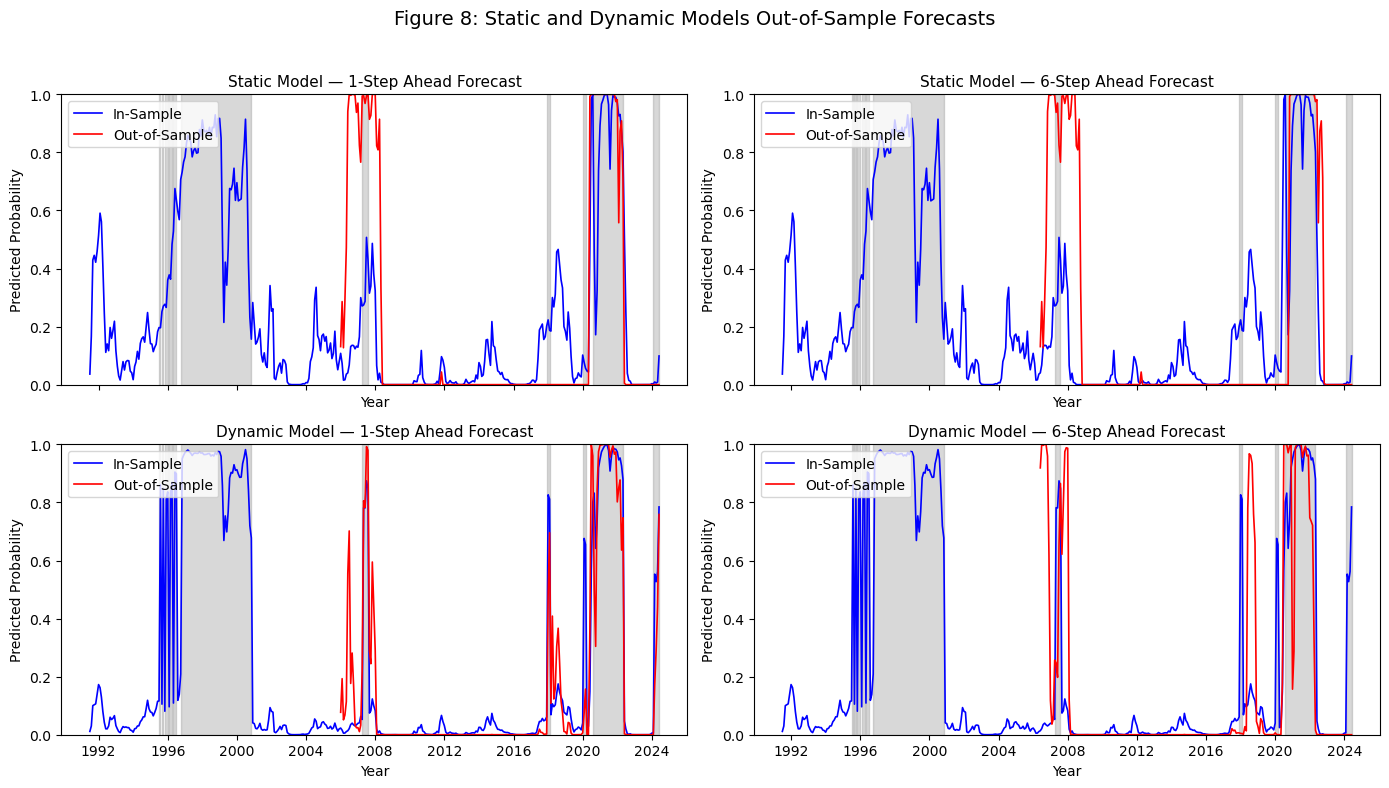

In [24]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# =====================================================
# 1. Load and prepare data
# =====================================================
data = pd.read_csv("Data_with_Bubbles_Renamed.csv", parse_dates=["Date"])
data = data.set_index("Date")

lags = {
    "Real_Rate": 6,
    "TR_CAPE": 6,
    "M2": 3,
    "Gold": 1,
    "Baa_Spread": 6,
    "VIX": 1,
    "BankCredit": 6,
    "Michigan_Sentiment": 6,
    "Policy_Deviations": 6,
}

for var, lag in lags.items():
    data[f"{var}_lag{lag}"] = data[var].shift(lag)

data["Bubble_lag1"] = data["Bubble"].shift(1)
data = data.dropna()

# Train/test split
train = data.loc[:'2005-12-31'].copy()
test = data.loc['2006-01-01':].copy()

# =====================================================
# 2. Forecasting functions (same as Table 9)
# =====================================================
X_train_static = sm.add_constant(train[[f"{var}_lag{lag}" for var, lag in lags.items()]])
y_train = train["Bubble"]
model_static = sm.Probit(y_train, X_train_static).fit(disp=0)

def forecast_static(h):
    preds = []
    for i in range(len(test) - h + 1):
        Xh = test.iloc[i][[f"{var}_lag{lag}" for var, lag in lags.items()]]
        Xh = sm.add_constant(pd.DataFrame([Xh]), has_constant="add")
        prob = model_static.predict(Xh).iloc[0]
        preds.append((test.index[i + h - 1], prob))
    return pd.Series(dict(preds))

def forecast_dynamic(h):
    preds = []
    full_data = data.copy()
    for i in range(len(test) - h + 1):
        # Expanding training window
        end_idx = len(train) + i
        sample = full_data.iloc[:end_idx]
        y_dyn = sample["Bubble"]
        X_dyn = sample[[f"{var}_lag{lag}" for var, lag in lags.items()] + ["Bubble_lag1"]]
        X_dyn = sm.add_constant(X_dyn)
        model_dyn = sm.Probit(y_dyn, X_dyn).fit(disp=0)

        bubble_lag = test.iloc[i]["Bubble_lag1"]
        for step in range(h):
            Xh = test.iloc[i + step][[f"{var}_lag{lag}" for var, lag in lags.items()]].copy()
            Xh["Bubble_lag1"] = bubble_lag
            Xh = sm.add_constant(pd.DataFrame([Xh]), has_constant="add")
            prob = model_dyn.predict(Xh).iloc[0]
            bubble_lag = 1 if prob >= 0.5 else 0
        preds.append((test.index[i + h - 1], prob))
    return pd.Series(dict(preds))

# =====================================================
# 3. Full-sample in-sample fits
# =====================================================
y_full = data["Bubble"]

X_full_static = sm.add_constant(data[[f"{var}_lag{lag}" for var, lag in lags.items()]])
model_static_full = sm.Probit(y_full, X_full_static).fit(disp=0)
fit_static_full = model_static_full.predict(X_full_static)

X_full_dynamic = sm.add_constant(data[[f"{var}_lag{lag}" for var, lag in lags.items()] + ["Bubble_lag1"]])
model_dynamic_full = sm.Probit(y_full, X_full_dynamic).fit(disp=0)
fit_dynamic_full = model_dynamic_full.predict(X_full_dynamic)

# =====================================================
# 4. Get forecasts for horizons 1 and 6
# =====================================================
f_static_1 = forecast_static(1)
f_static_6 = forecast_static(6)
f_dynamic_1 = forecast_dynamic(1)
f_dynamic_6 = forecast_dynamic(6)

# =====================================================
# 5. Plotting helper
# =====================================================
def plot_forecast(ax, fit_series, forecast_series, title):
    # In-sample (blue, full period)
    ax.plot(fit_series.index, fit_series, label="In-Sample", color="blue", linewidth=1.2)
    # Out-of-sample (red, from 2006)
    ax.plot(forecast_series.index, forecast_series, label="Out-of-Sample", color="red", linewidth=1.2)

    # Shade bubble periods
    in_bubble = False
    start = None
    for date, val in data["Bubble"].items():
        if val == 1 and not in_bubble:
            start = date
            in_bubble = True
        elif val == 0 and in_bubble:
            ax.axvspan(start, date, color="gray", alpha=0.3)
            in_bubble = False
    if in_bubble:
        ax.axvspan(start, data.index[-1], color="gray", alpha=0.3)

    ax.set_title(title, fontsize=11)
    ax.set_ylim(0, 1)
    ax.set_ylabel("Predicted Probability")
    ax.legend(loc="upper left")

# =====================================================
# 6. Build Figure 8
# =====================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

plot_forecast(axes[0,0], fit_static_full, f_static_1, "Static Model — 1-Step Ahead Forecast")
plot_forecast(axes[0,1], fit_static_full, f_static_6, "Static Model — 6-Step Ahead Forecast")
plot_forecast(axes[1,0], fit_dynamic_full, f_dynamic_1, "Dynamic Model — 1-Step Ahead Forecast")
plot_forecast(axes[1,1], fit_dynamic_full, f_dynamic_6, "Dynamic Model — 6-Step Ahead Forecast")

for ax in axes.flat:
    ax.set_xlabel("Year")

fig.suptitle("Figure 8: Static and Dynamic Models Out-of-Sample Forecasts", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.savefig("Figure8_Out_of_Sample.png", dpi=300)
plt.show()


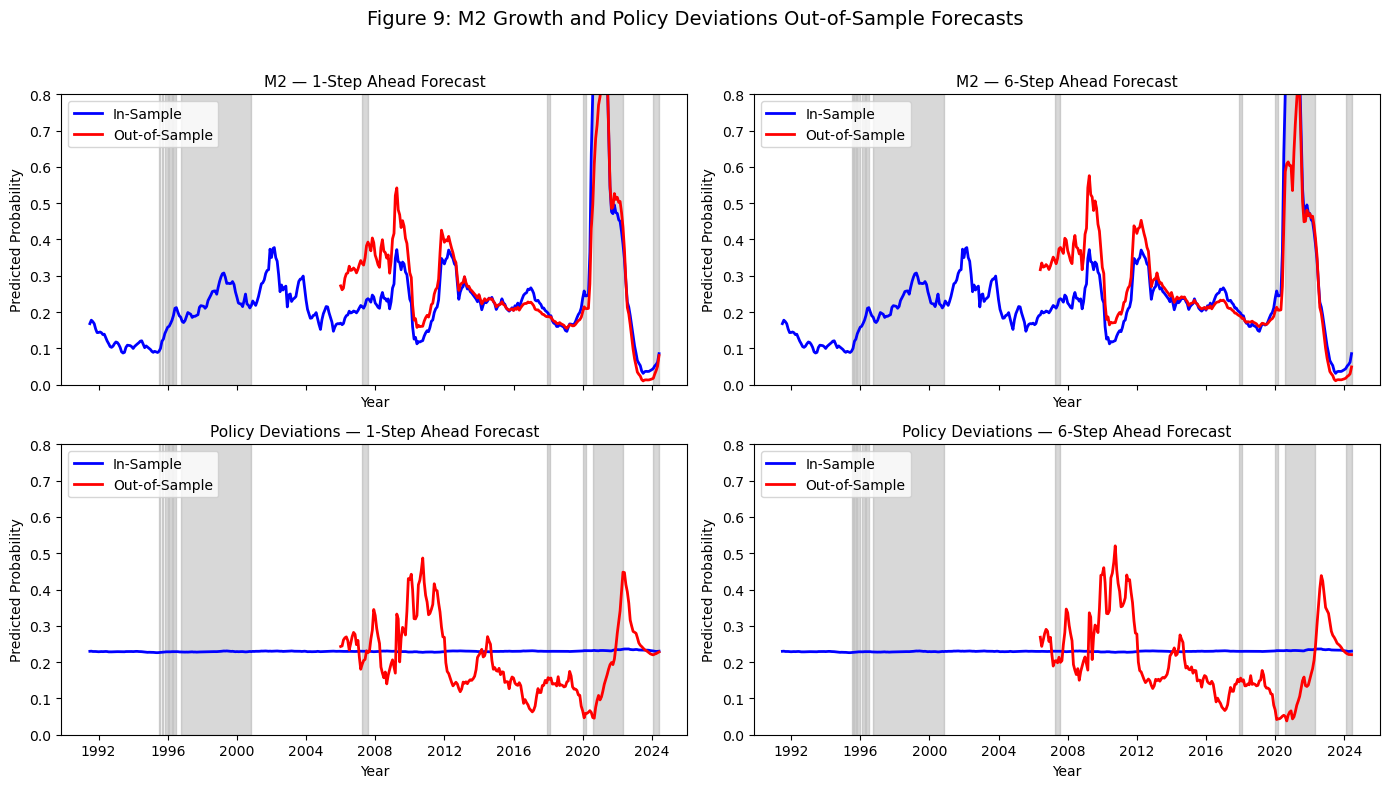

In [25]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# =====================================================
# 1. Univariate forecasting (direct + iterative)
# =====================================================
def forecast_univariate(var, lag, h):
    preds = []
    full_data = data.copy()

    for i in range(len(test) - h + 1):
        # Expanding training window
        end_idx = len(train) + i
        sample = full_data.iloc[:end_idx]

        y_uni = sample["Bubble"]
        X_uni = sm.add_constant(sample[[f"{var}_lag{lag}"]])
        model_uni = sm.Probit(y_uni, X_uni).fit(disp=0)

        # Iterative forecast out to horizon h
        for step in range(h):
            Xh = test.iloc[i + step][[f"{var}_lag{lag}"]]
            Xh = sm.add_constant(pd.DataFrame([Xh]), has_constant="add")
            prob = model_uni.predict(Xh).iloc[0]

        preds.append((test.index[i + h - 1], prob))

    return pd.Series(dict(preds))

# =====================================================
# 2. Full-sample in-sample fits
# =====================================================
def fit_univariate(var, lag):
    X = sm.add_constant(data[[f"{var}_lag{lag}"]])
    y = data["Bubble"]
    model = sm.Probit(y, X).fit(disp=0)
    return model.predict(X)

fit_m2 = fit_univariate("M2", 3)
fit_policy = fit_univariate("Policy_Deviations", 6)

# =====================================================
# 3. Get out-of-sample forecasts (1-step and 6-step)
# =====================================================
f_m2_1 = forecast_univariate("M2", 3, 1)
f_m2_6 = forecast_univariate("M2", 3, 6)
f_policy_1 = forecast_univariate("Policy_Deviations", 6, 1)
f_policy_6 = forecast_univariate("Policy_Deviations", 6, 6)

# =====================================================
# 4. Plotting helper
# =====================================================
def plot_forecast(ax, fit_series, forecast_series, title):
    # In-sample (blue, full period)
    ax.plot(fit_series.index, fit_series, label="In-Sample", 
            color="blue", linewidth=2)
    # Out-of-sample (red, from 2006)
    ax.plot(forecast_series.index, forecast_series, label="Out-of-Sample", 
            color="red", linewidth=2)

    # Shade bubble periods
    in_bubble = False
    start = None
    for date, val in data["Bubble"].items():
        if val == 1 and not in_bubble:
            start = date
            in_bubble = True
        elif val == 0 and in_bubble:
            ax.axvspan(start, date, color="gray", alpha=0.3)
            in_bubble = False
    if in_bubble:
        ax.axvspan(start, data.index[-1], color="gray", alpha=0.3)

    ax.set_title(title, fontsize=11)
    ax.set_ylim(0, 0.8)  # zoom in to make lines more profound
    ax.set_ylabel("Predicted Probability")
    ax.legend(loc="upper left")

# =====================================================
# 5. Build Figure 9
# =====================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

plot_forecast(axes[0,0], fit_m2, f_m2_1, "M2 — 1-Step Ahead Forecast")
plot_forecast(axes[0,1], fit_m2, f_m2_6, "M2 — 6-Step Ahead Forecast")
plot_forecast(axes[1,0], fit_policy, f_policy_1, "Policy Deviations — 1-Step Ahead Forecast")
plot_forecast(axes[1,1], fit_policy, f_policy_6, "Policy Deviations — 6-Step Ahead Forecast")

for ax in axes.flat:
    ax.set_xlabel("Year")

fig.suptitle("Figure 9: M2 Growth and Policy Deviations Out-of-Sample Forecasts", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.savefig("Figure9_Out_of_Sample_Zoomed.png", dpi=300)
plt.show()
